# Task 1: Preprocess the Data

In [1]:
# Install necessary libraries
!pip3 install transformers datasets scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from transformers import AutoTokenizer
import numpy as np
import datasets
import matplotlib.pyplot as plt
from scipy.stats import zscore


In [9]:
# Load the GoEmotions dataset from Hugging Face
def load_dataset():
    dataset = datasets.load_dataset("go_emotions")
    # Merge splits for preprocessing and splitting manually
    data = pd.concat([
        pd.DataFrame(dataset['train']),
        pd.DataFrame(dataset['validation']),
        pd.DataFrame(dataset['test'])
    ])
    # Drop rows with multiple labels
    data = data[data['labels'].apply(lambda x: len(x) == 1)]
    # Convert labels to a integer value
    data['labels'] = data['labels'].apply(lambda x: x[0])

    # Retrieve the emotion label names
    emotions = dataset['train'].features['labels'].feature.names
    return data, emotions

# Load and display basic info about the dataset
data, emotions = load_dataset()


In [17]:
# Split the dataset into train, validation, and test sets
train_data, temp_data = train_test_split(data, test_size=0.3, random_state=19)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=19)

print(f"Training size: {train_data.shape}, Validation size: {val_data.shape}, Test size: {test_data.shape}")


Training size: (31812, 4), Validation size: (6817, 4), Test size: (6817, 4)


In [18]:
def preprocess_for_baseline_zscore(data, top_n=1000):
    # First, vectorize without max_features to get the full vocabulary
    vectorizer = CountVectorizer(stop_words='english')  # Adjust parameters as needed
    X_full = vectorizer.fit_transform(data['text'])
    feature_names = np.array(vectorizer.get_feature_names_out())

    # Compute the mean frequency of each feature across all documents
    # X_full is a sparse matrix, so we convert frequencies:
    # mean frequency per feature = sum of that feature column / number of documents
    feature_sums = np.array(X_full.sum(axis=0)).flatten()   # Sum across all docs for each feature
    feature_means = feature_sums / X_full.shape[0]          # Mean frequency per feature

    # Compute z-scores of these mean frequencies
    z_scores = zscore(feature_means)

    # Select top_n features by absolute z-score
    top_features_idx = np.argsort(np.abs(z_scores))[-top_n:]  # Indices of top_n features
    selected_features = feature_names[top_features_idx]

    # Create a new vectorizer that uses only the selected features
    # This ensures the transformation aligns train/val/test consistently
    final_vectorizer = CountVectorizer(vocabulary=selected_features)
    X = final_vectorizer.fit_transform(data['text']).toarray()
    y = data['labels'].values

    return X, y, selected_features

# Preprocess data for baseline models with z-score based feature selection
X_train_baseline, y_train_baseline, selected_features = preprocess_for_baseline_zscore(train_data, top_n=1000)
X_val_baseline, y_val_baseline, _ = preprocess_for_baseline_zscore(val_data, top_n=1000)
X_test_baseline, y_test_baseline, _ = preprocess_for_baseline_zscore(test_data, top_n=1000)

print(f"Selected top 1000 features based on z-scores:\n{selected_features}")


Selected top 1000 features based on z-scores:
['false' 'feet' 'subs' 'sir' 'reasonable' 'return' 'language' 'door'
 'cares' 'idiots' 'fighting' 'period' 'finish' 'rare' 'quickly' 'helped'
 'playoffs' 'shoes' 'fucked' 'light' 'added' 'ahead' 'highly'
 'understanding' 'states' 'force' 'solid' 'hugs' 'tough' 'sitting' 'local'
 'irony' 'till' 'rules' 'action' '000' 'daughter' '14' 'positive' 'dating'
 'damage' 'calls' 'places' 'value' 'stuck' 'cheating' 'silly' 'chicken'
 'saved' 'btw' 'regardless' 'loving' 'rule' 'quit' 'busy' 'american'
 'million' 'snow' 'deep' 'simple' 'constantly' 'garbage' 'keeping' 'waste'
 'hearing' 'tears' 'tip' 'deserves' 'anyways' 'knowing' 'walking' 'starts'
 'bud' 'spot' 'evil' 'town' 'la' 'animals' 'enjoyed' 'art' 'earth' 'eh'
 'stories' 'complete' 'channel' 'sexual' 'congratulations' 'draft' 'dogs'
 'realized' 'soul' 'content' 'holding' 'consider' 'ignorant' 'sister'
 'recently' 'slow' 'south' 'president' 'text' 'opinions' 'calm' 'learned'
 'bigger' 'wtf' 'ex

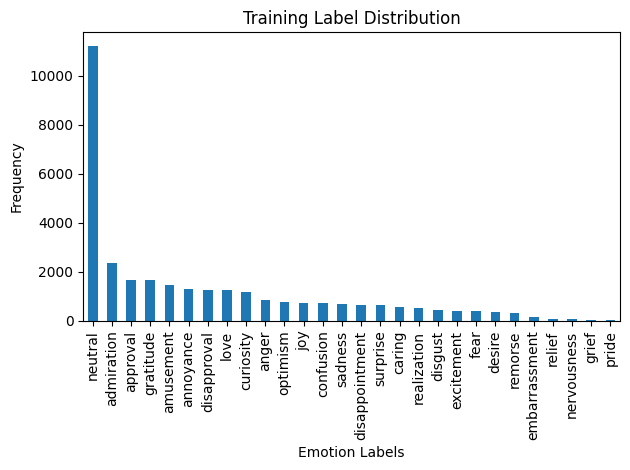

In [13]:
def plot_label_distribution(data, emotion_names, title="Label Distribution"):
    label_counts = data['labels'].value_counts()
    # Map the numeric indices to their emotion names
    label_counts.index = label_counts.index.map(lambda x: emotion_names[x])

    label_counts.plot(kind='bar')
    plt.title(title)
    plt.xlabel('Emotion Labels')
    plt.ylabel('Frequency')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

plot_label_distribution(train_data, emotions, "Training Label Distribution")


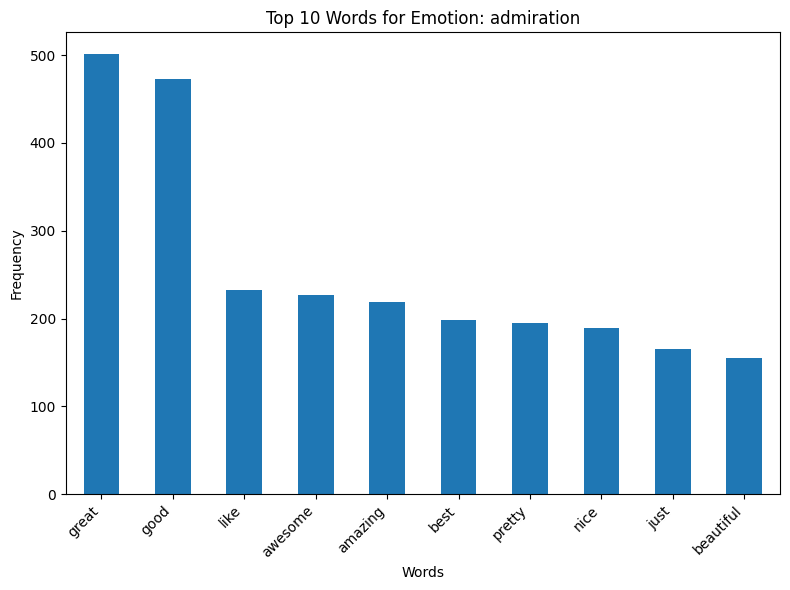

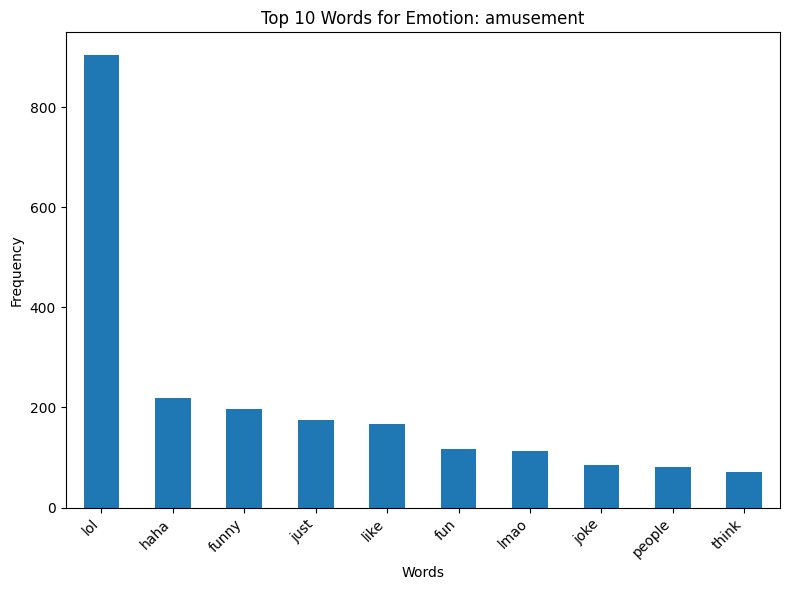

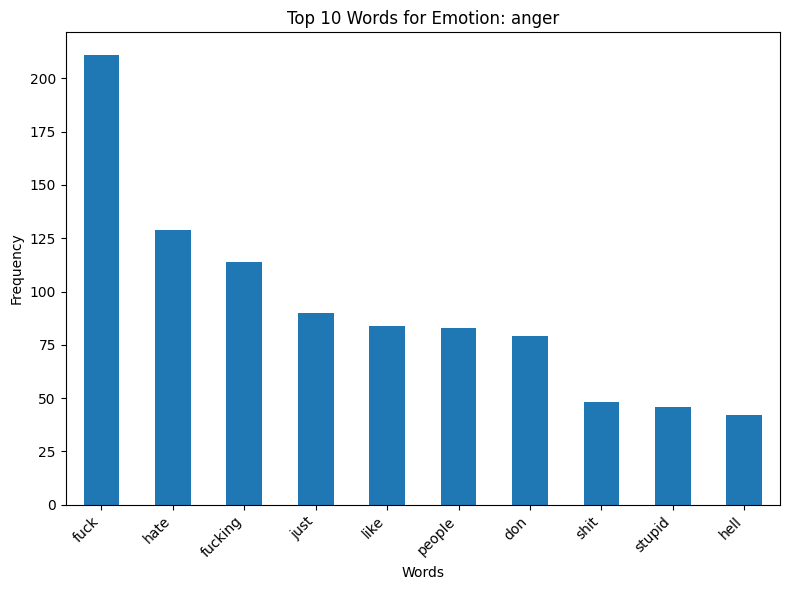

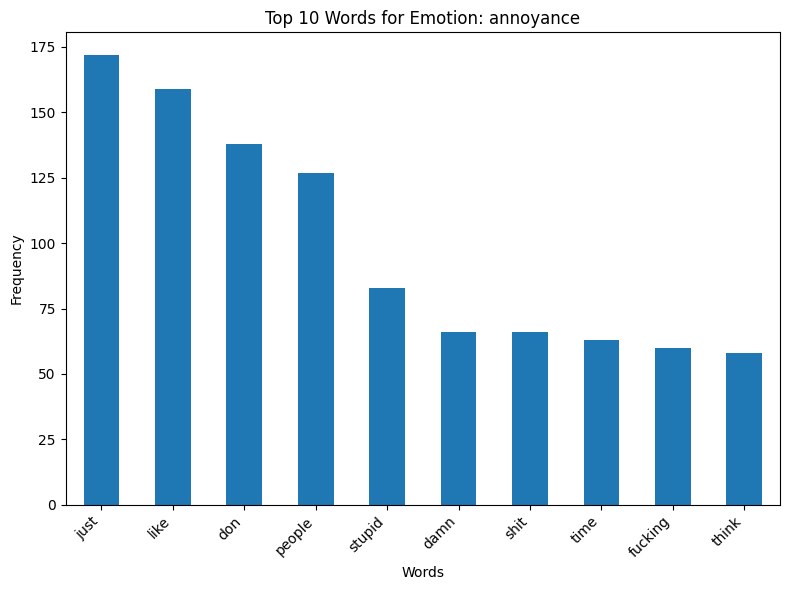

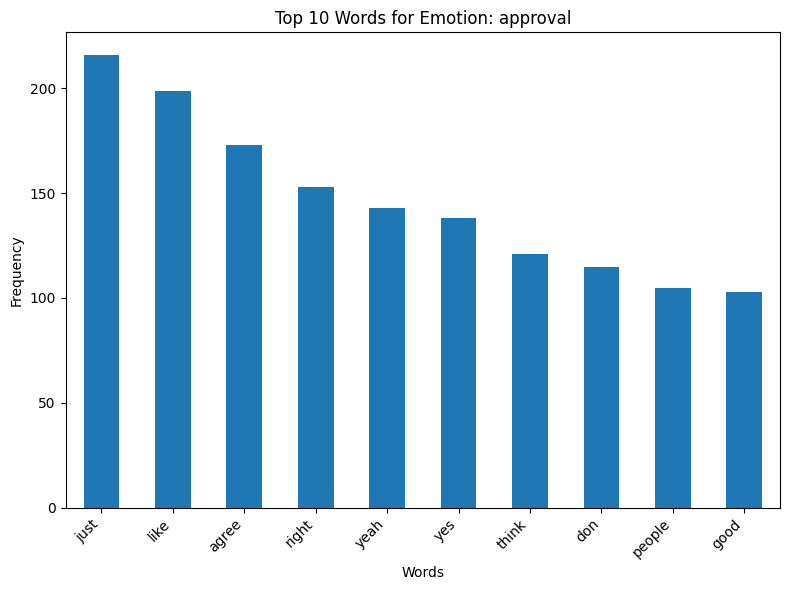

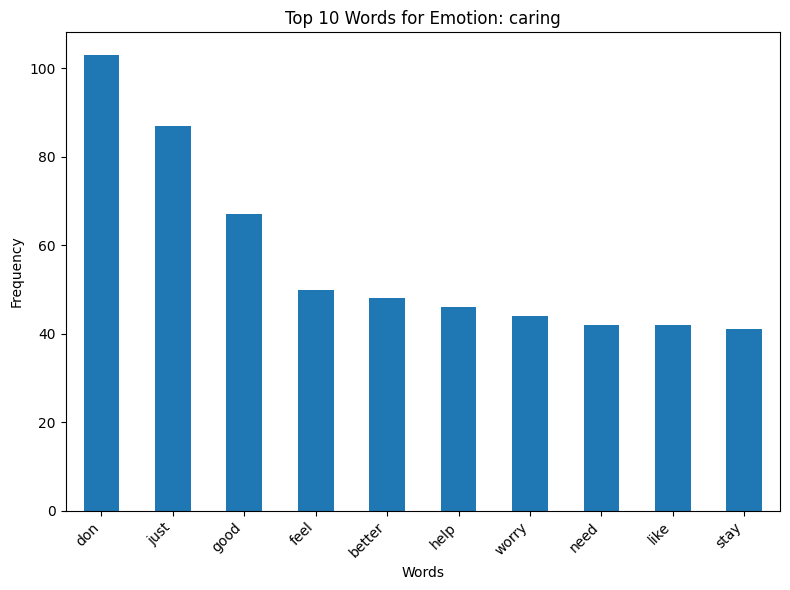

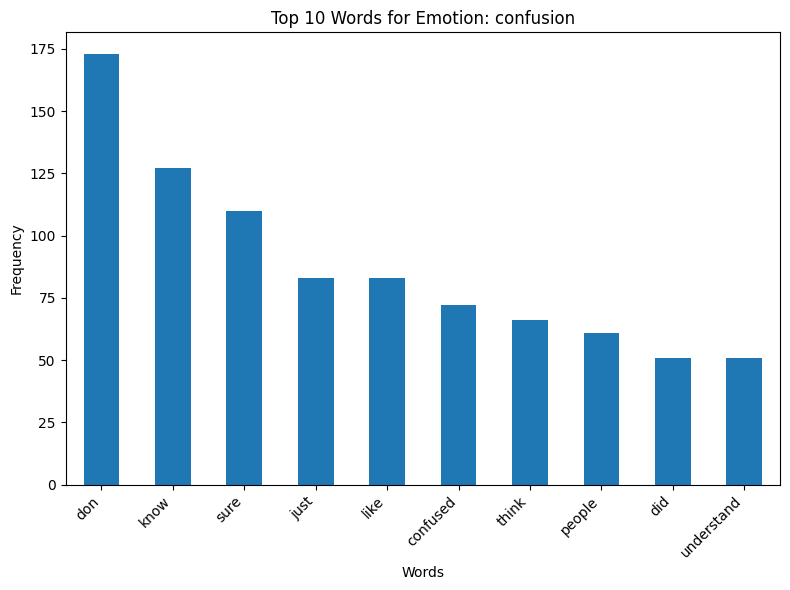

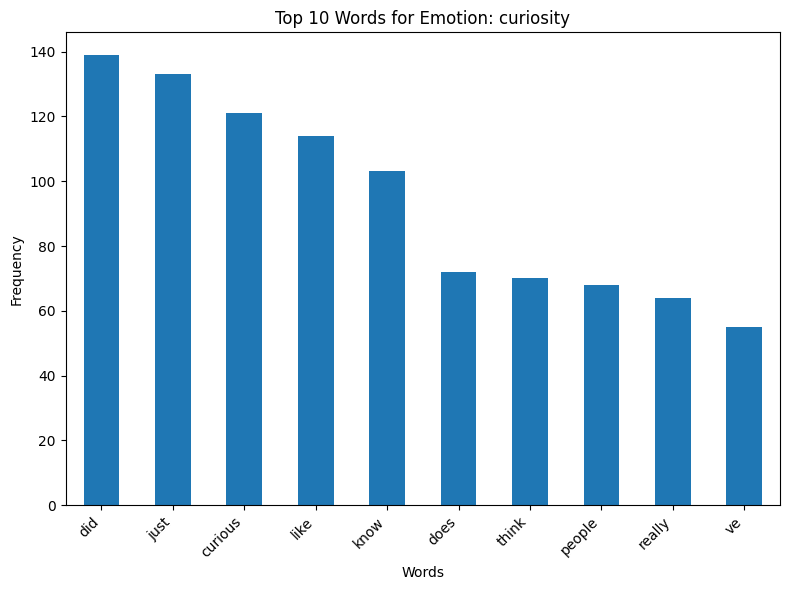

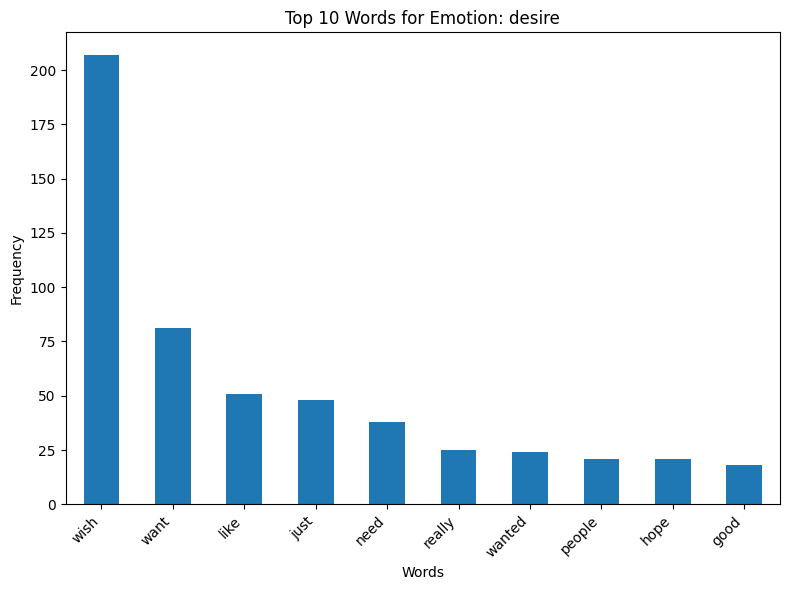

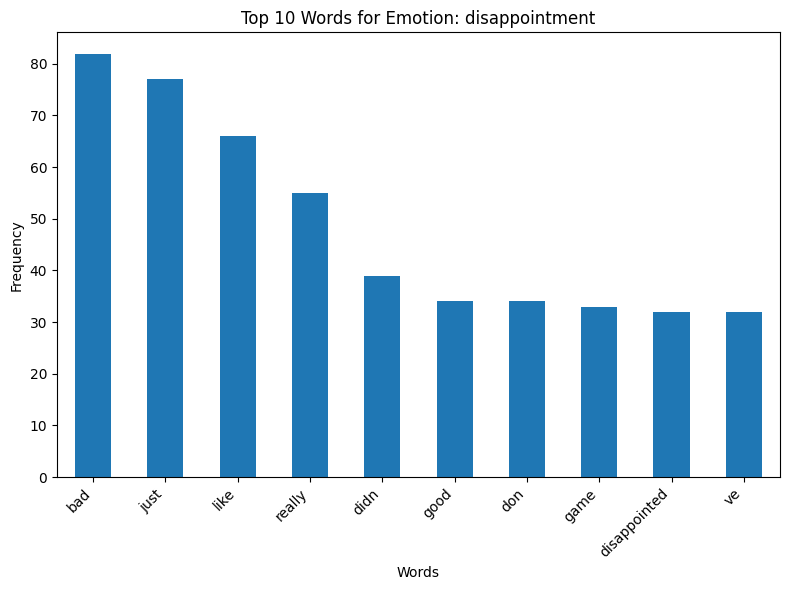

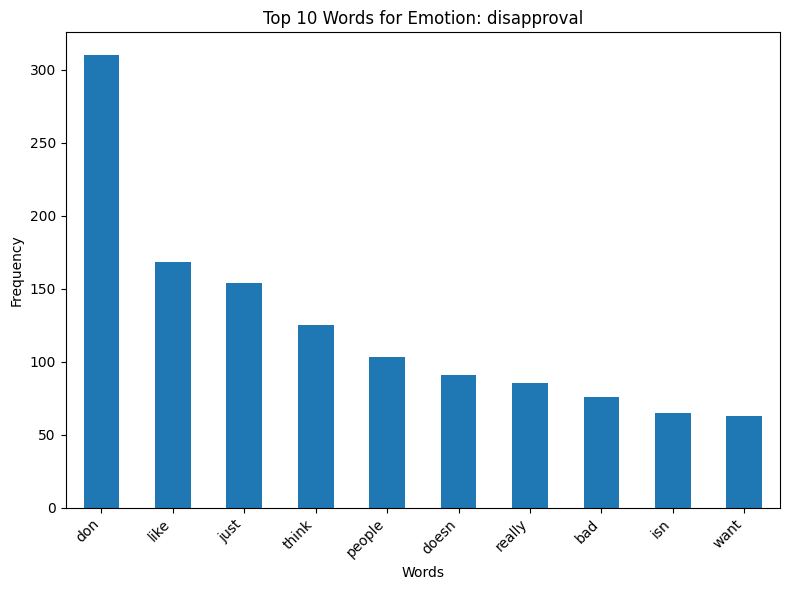

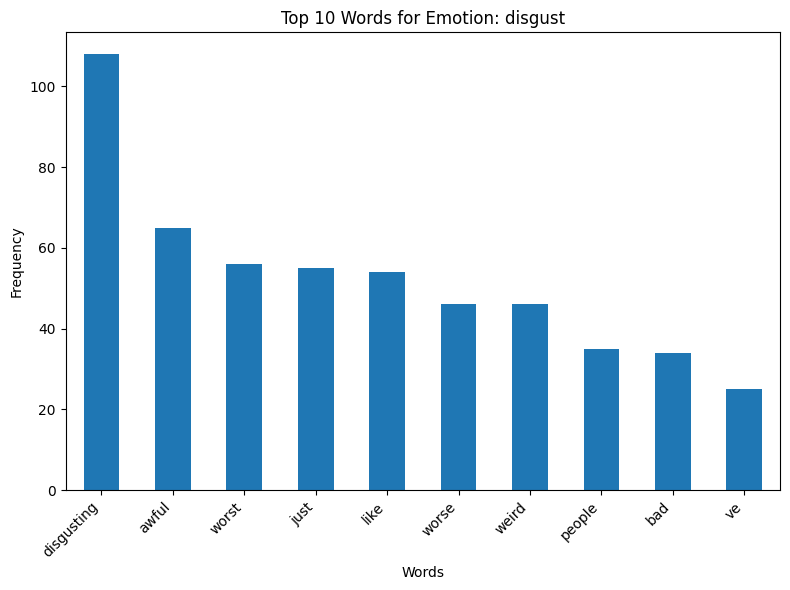

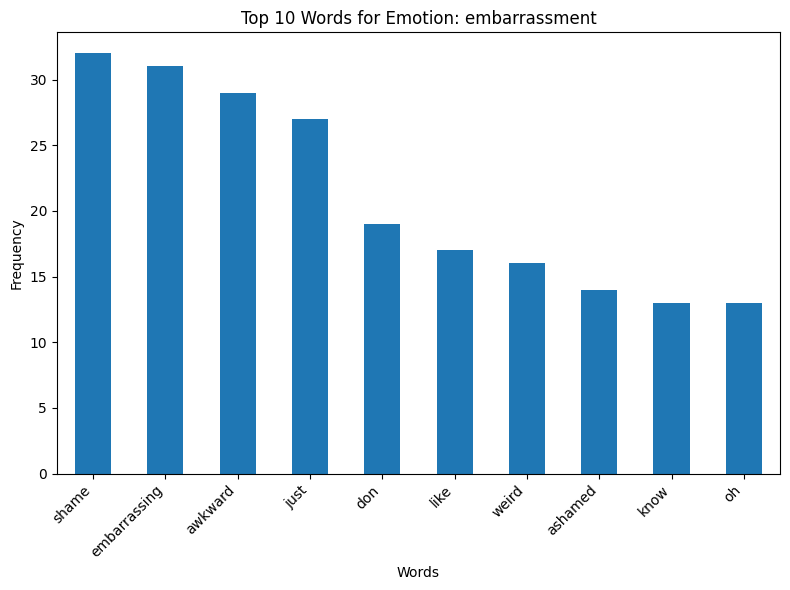

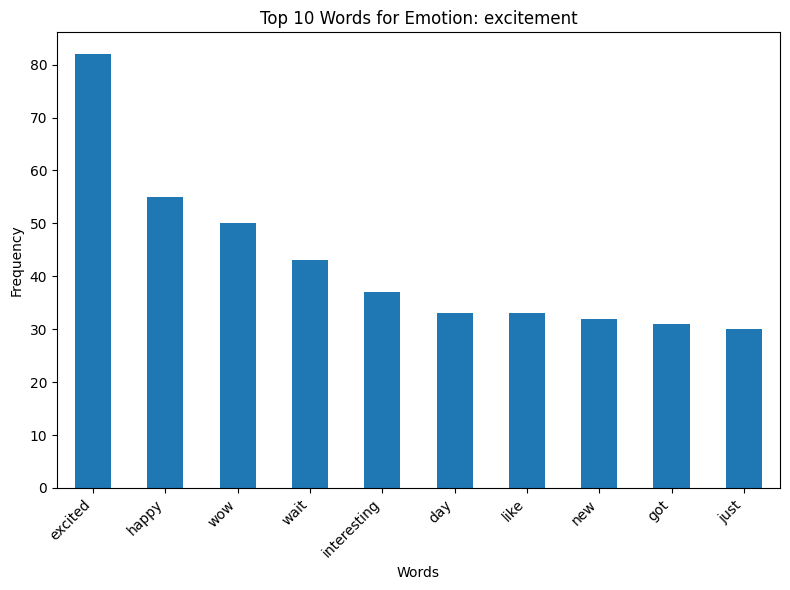

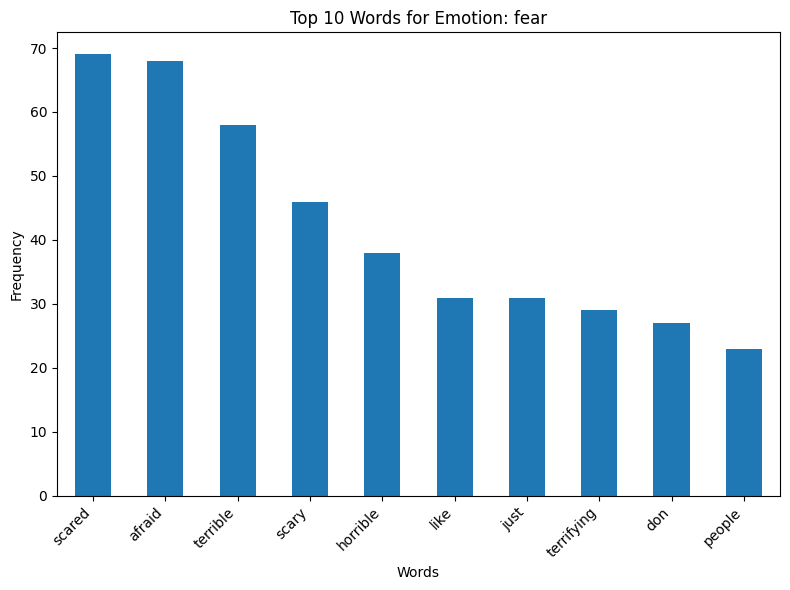

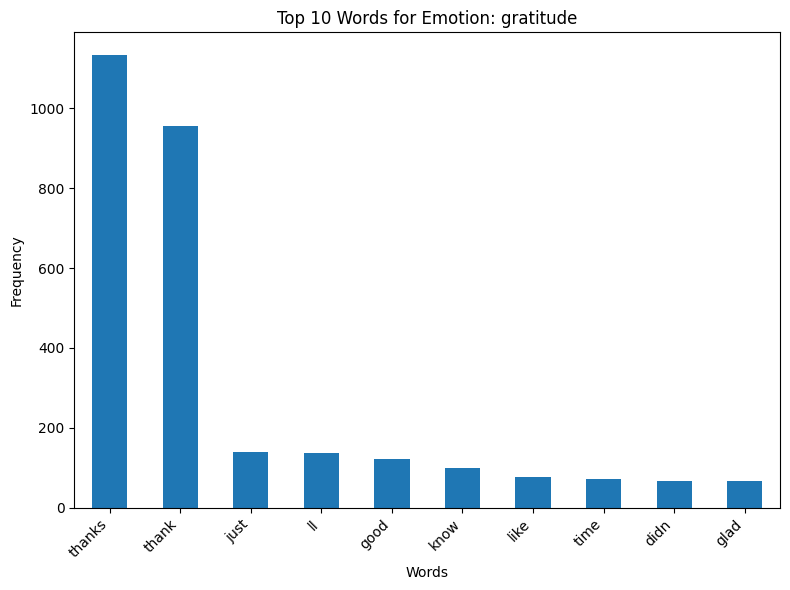

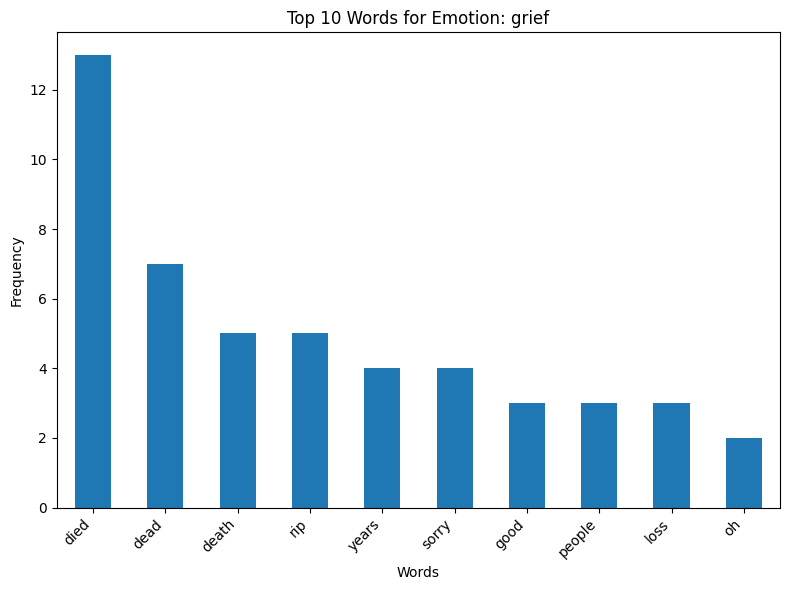

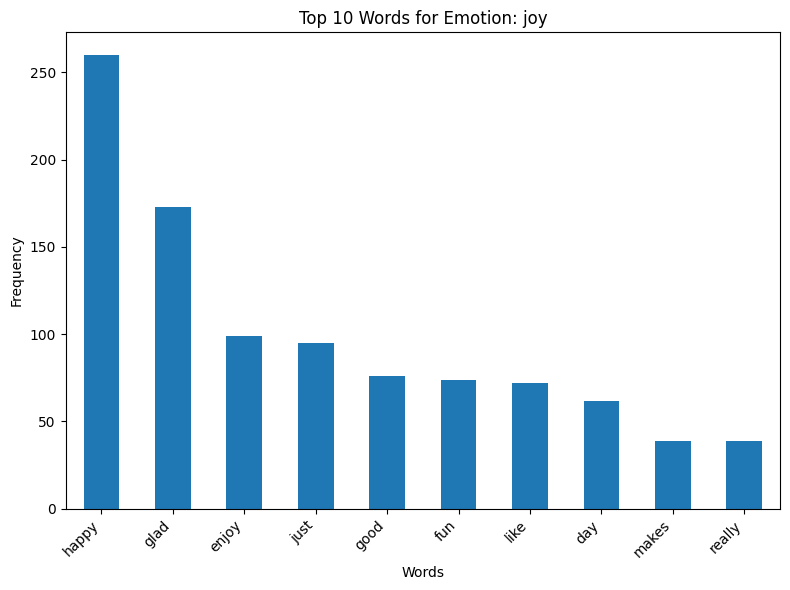

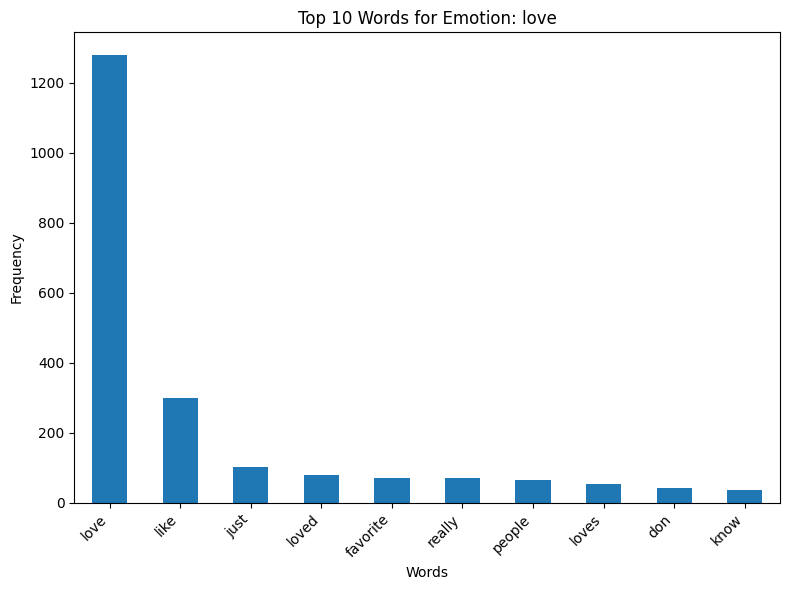

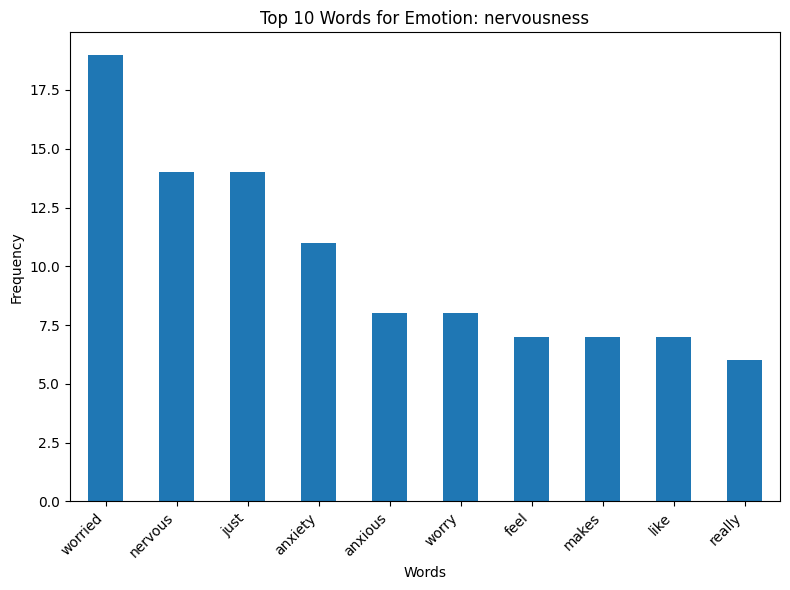

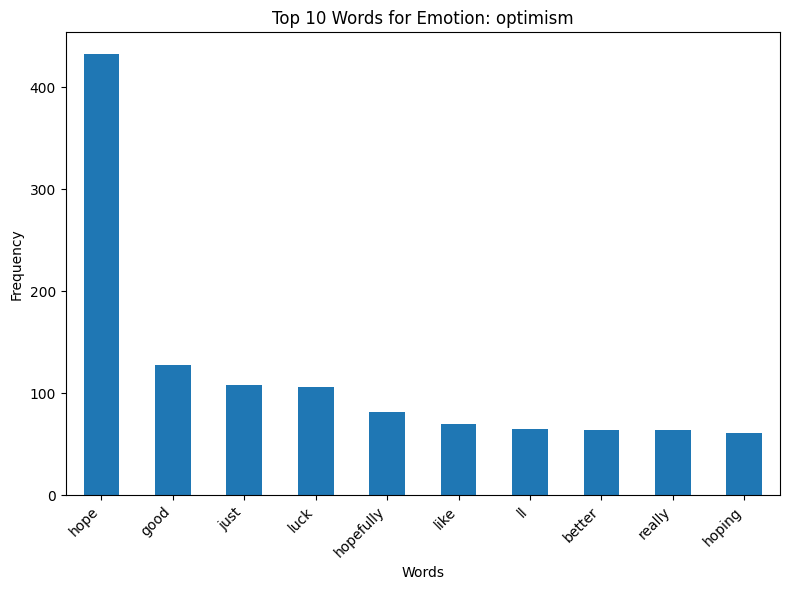

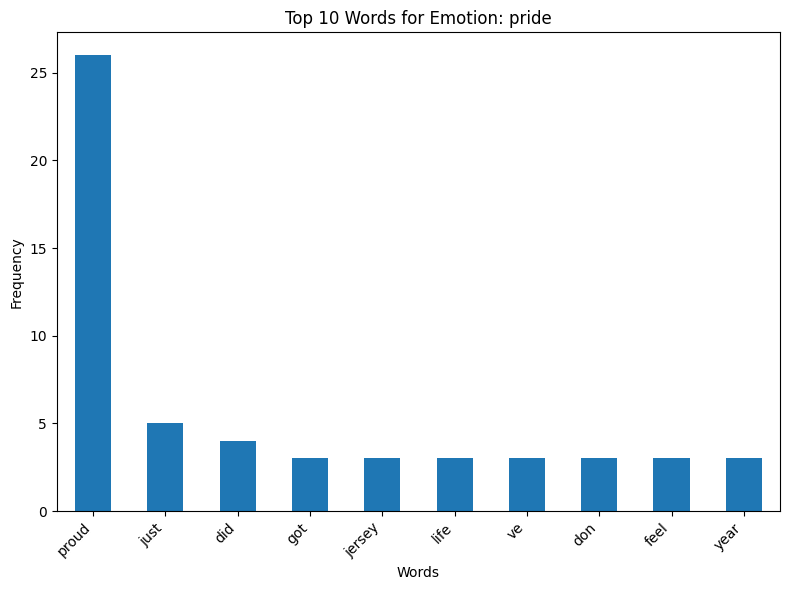

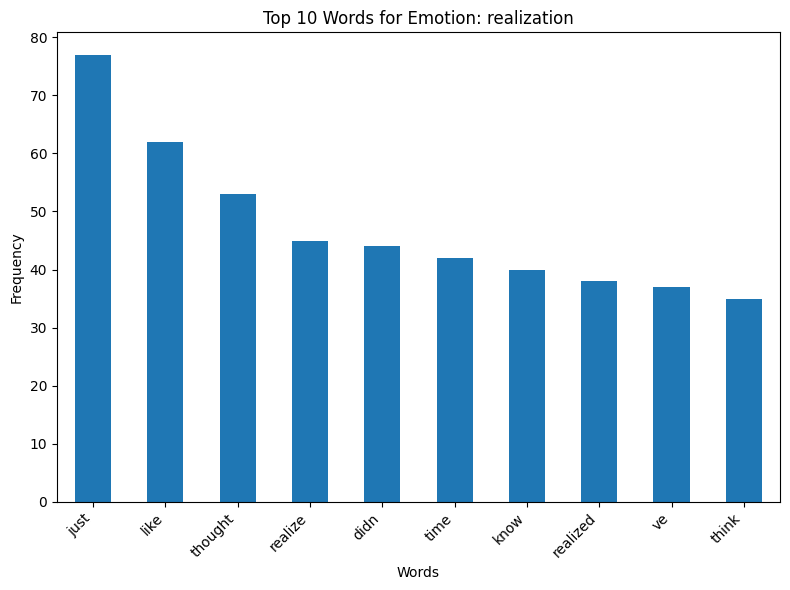

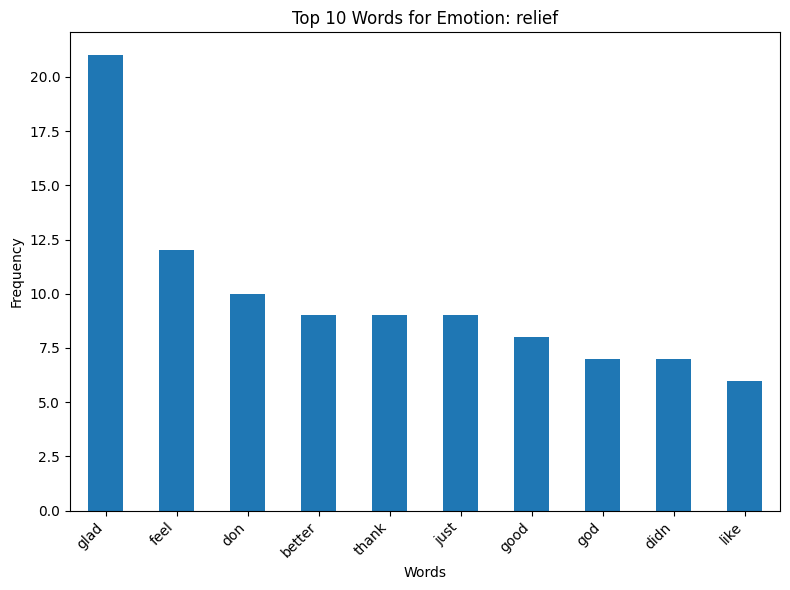

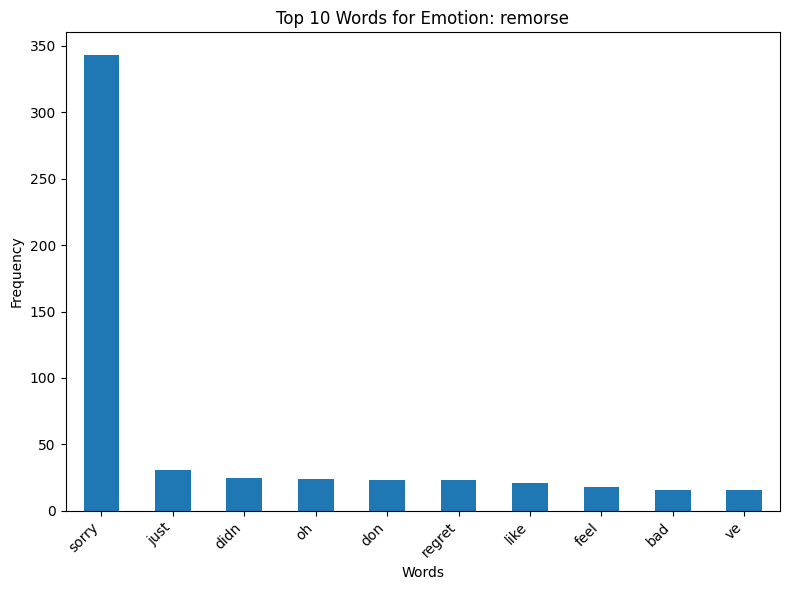

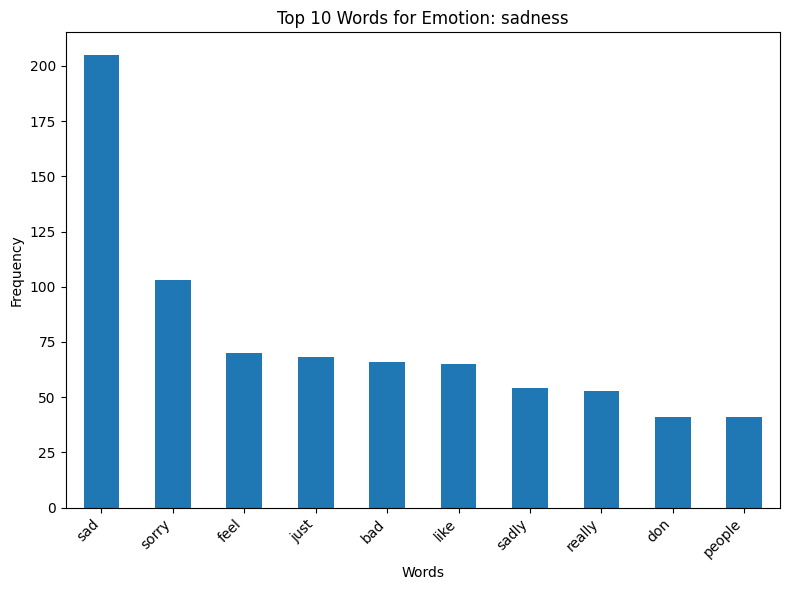

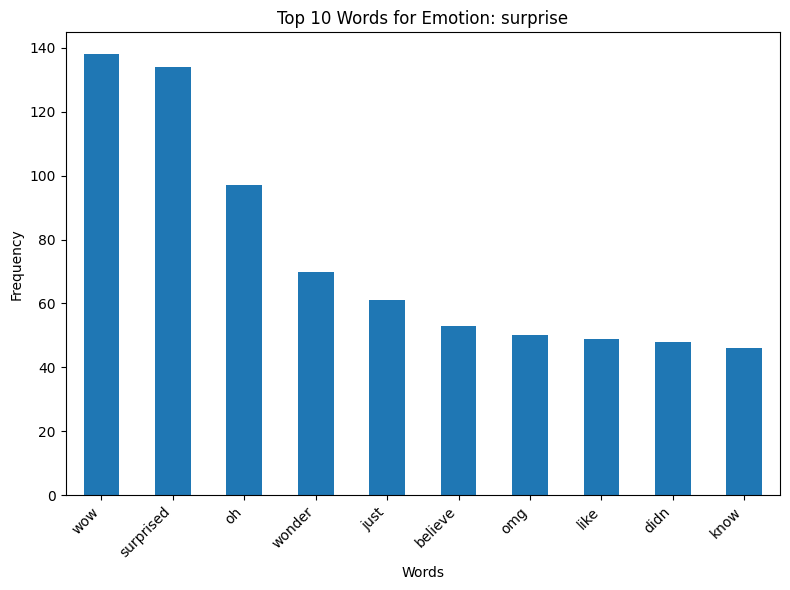

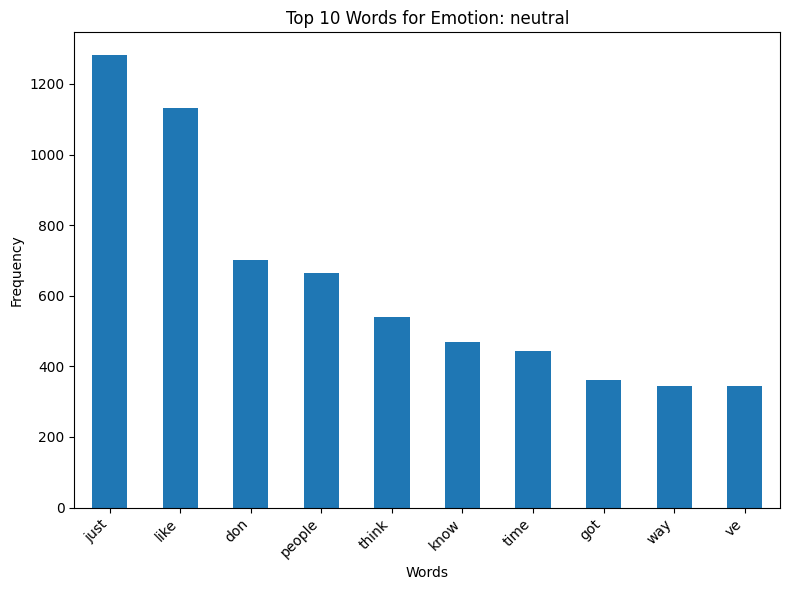

In [14]:
def top_words_per_class(data, emotion_names, top_n=10):
    # Vectorize the text
    vectorizer = CountVectorizer(stop_words='english', max_features=2000)
    X = vectorizer.fit_transform(data['text'])
    feature_names = vectorizer.get_feature_names_out()

    # Create a DataFrame that links each sample's features to its label
    df_features = pd.DataFrame(X.toarray(), columns=feature_names)
    df_features['label'] = data['labels'].values

    # Compute top words for each class
    for label_idx in range(len(emotion_names)):
        class_data = df_features[df_features['label'] == label_idx]
        word_sums = class_data[feature_names].sum().sort_values(ascending=False).head(top_n)

        plt.figure(figsize=(8,6))
        word_sums.plot(kind='bar')
        plt.title(f"Top {top_n} Words for Emotion: {emotion_names[label_idx]}")
        plt.xlabel("Words")
        plt.ylabel("Frequency")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()

top_words_per_class(data, emotions, top_n=10)


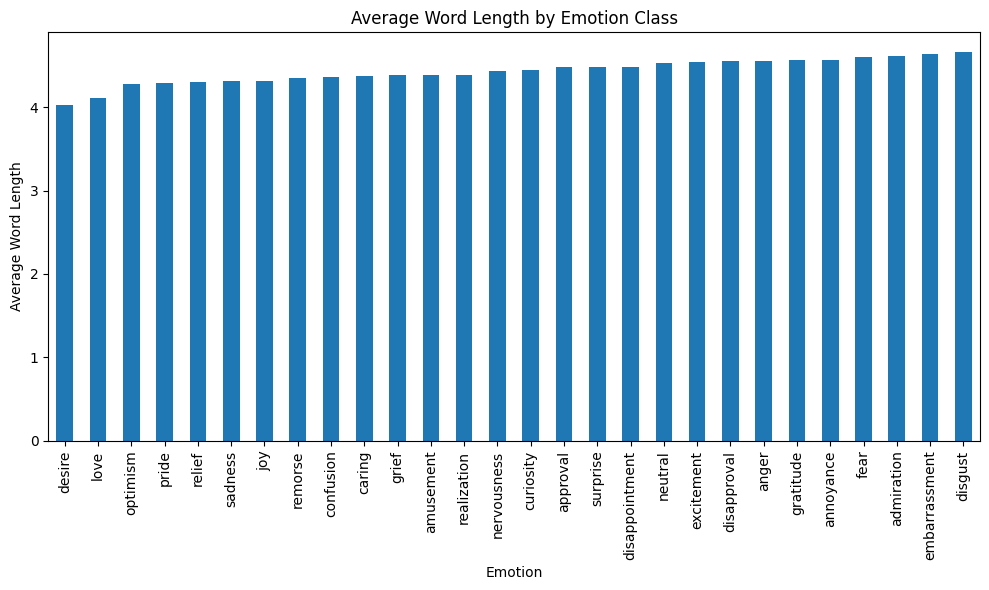

In [15]:
def plot_average_word_length(data, emotion_names):
    def avg_word_length(text):
        words = text.split()
        return np.mean([len(w) for w in words]) if words else 0

    data['avg_word_length'] = data['text'].apply(avg_word_length)
    avg_word_len_per_class = data.groupby('labels')['avg_word_length'].mean()
    avg_word_len_per_class.index = avg_word_len_per_class.index.map(lambda x: emotion_names[x])

    avg_word_len_per_class.sort_values().plot(kind='bar', figsize=(10,6))
    plt.title("Average Word Length by Emotion Class")
    plt.xlabel("Emotion")
    plt.ylabel("Average Word Length")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

plot_average_word_length(data, emotions)


# Task 2: Implement Baseline Models

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report


## Baseline SR, RF and XGBoost Models

In [20]:
# Train SR model on training set and evaluate on validation set
def train_softmax_regression(X_train, y_train, X_val, y_val):
    print("\n ---Training SR Model---")

    sr_model = LogisticRegression(multi_class="multinomial", max_iter=500, solver="lbfgs", random_state=19)
    sr_model.fit(X_train, y_train)

    y_val_pred = sr_model.predict(X_val)
    acc = accuracy_score(y_val, y_val_pred)

    print(f"SR Accuracy: {acc:.4f}")
    print(classification_report(y_val, y_val_pred))
    return sr_model

# Train RF model on training set and evaluate on validation set
def train_random_forest(X_train, y_train, X_val, y_val):
    print("\n ---Training RF Model---")
    rf_model = RandomForestClassifier(n_estimators=100, random_state=18)
    rf_model.fit(X_train, y_train)

    y_val_pred = rf_model.predict(X_val)
    acc = accuracy_score(y_val, y_val_pred)

    print(f"RF Accuracy: {acc:.4f}")
    print(classification_report(y_val, y_val_pred))
    return rf_model

# Train XGBoost model on training set and evaluate on validation set
def train_xgboost(X_train, y_train, X_val, y_val):
    print("\n ---Training XGBoost---")

    xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=17)
    xgb_model.fit(X_train, y_train)

    y_val_pred = xgb_model.predict(X_val)
    acc = accuracy_score(y_val, y_val_pred)

    print(f"XGBoost Accuracy: {acc:.4f}")
    print(classification_report(y_val, y_val_pred))
    return xgb_model


In [21]:
# Train and evaluate all models
def run_baseline_models(X_train, y_train, X_val, y_val):
    # Softmax Regression
    sr_model = train_softmax_regression(X_train, y_train, X_val, y_val)

    # Random Forest
    rf_model = train_random_forest(X_train, y_train, X_val, y_val)

    # XGBoost
    xgb_model = train_xgboost(X_train, y_train, X_val, y_val)

    return sr_model, rf_model, xgb_model


# Task 3 - Run Experiments

In [22]:
# Evaluate Softmax Regression
print("\nEvaluating Softmax Regression...")
sr_model = train_softmax_regression(X_train_baseline, y_train_baseline, X_val_baseline, y_val_baseline)
y_test_pred_sr = sr_model.predict(X_test_baseline)
accuracy_sr = accuracy_score(y_test_baseline, y_test_pred_sr)
print(f"Softmax Regression Test Accuracy: {accuracy_sr:.4f}")
print(classification_report(y_test_baseline, y_test_pred_sr))

# Evaluate Random Forest
print("\nEvaluating Random Forest...")
rf_model = train_random_forest(X_train_baseline, y_train_baseline, X_val_baseline, y_val_baseline)
y_test_pred_rf = rf_model.predict(X_test_baseline)
accuracy_rf = accuracy_score(y_test_baseline, y_test_pred_rf)
print(f"Random Forest Test Accuracy: {accuracy_rf:.4f}")
print(classification_report(y_test_baseline, y_test_pred_rf))

# Evaluate XGBoost
print("\nEvaluating XGBoost...")
xgb_model = train_xgboost(X_train_baseline, y_train_baseline, X_val_baseline, y_val_baseline)
y_test_pred_xgb = xgb_model.predict(X_test_baseline)
accuracy_xgb = accuracy_score(y_test_baseline, y_test_pred_xgb)
print(f"XGBoost Test Accuracy: {accuracy_xgb:.4f}")
print(classification_report(y_test_baseline, y_test_pred_xgb))


Evaluating Softmax Regression...

 ---Training SR Model---


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SR Accuracy: 0.2803
              precision    recall  f1-score   support

           0       0.09      0.07      0.08       511
           1       0.42      0.48      0.45       279
           2       0.00      0.00      0.00       221
           3       0.04      0.01      0.02       277
           4       0.05      0.02      0.03       321
           5       0.08      0.02      0.03       125
           6       0.04      0.01      0.02       169
           7       0.05      0.01      0.01       265
           8       0.00      0.00      0.00        61
           9       0.00      0.00      0.00       135
          10       0.10      0.02      0.04       281
          11       0.05      0.03      0.04        95
          12       0.00      0.00      0.00        41
          13       0.03      0.01      0.01       116
          14       0.02      0.01      0.02        82
          15       0.06      0.06      0.06       348
          16       0.00      0.00      0.00         4
       

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

RF Accuracy: 0.2429
              precision    recall  f1-score   support

           0       0.08      0.09      0.08       511
           1       0.40      0.45      0.43       279
           2       0.01      0.00      0.01       221
           3       0.05      0.02      0.03       277
           4       0.05      0.03      0.04       321
           5       0.05      0.02      0.02       125
           6       0.06      0.02      0.03       169
           7       0.02      0.01      0.02       265
           8       0.02      0.02      0.02        61
           9       0.03      0.01      0.01       135
          10       0.11      0.04      0.06       281
          11       0.06      0.04      0.05        95
          12       0.00      0.00      0.00        41
          13       0.02      0.01      0.01       116
          14       0.01      0.01      0.01        82
          15       0.06      0.06      0.06       348
          16       0.00      0.00      0.00         4
       

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Random Forest Test Accuracy: 0.2594
              precision    recall  f1-score   support

           0       0.15      0.17      0.16       525
           1       0.02      0.02      0.02       299
           2       0.06      0.04      0.05       191
           3       0.07      0.04      0.05       252
           4       0.08      0.05      0.06       368
           5       0.02      0.01      0.01       124
           6       0.12      0.06      0.08       156
           7       0.02      0.01      0.01       285
           8       0.02      0.01      0.02        68
           9       0.03      0.01      0.01       122
          10       0.04      0.02      0.03       251
          11       0.01      0.01      0.01        98
          12       0.00      0.00      0.00        38
          13       0.00      0.00      0.00        84
          14       0.03      0.02      0.02        89
          15       0.03      0.03      0.03       362
          16       0.00      0.00      0.00  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/xgboost/c

XGBoost Accuracy: 0.2808
              precision    recall  f1-score   support

           0       0.09      0.07      0.08       511
           1       0.38      0.47      0.42       279
           2       0.00      0.00      0.00       221
           3       0.04      0.01      0.01       277
           4       0.04      0.01      0.02       321
           5       0.07      0.01      0.01       125
           6       0.05      0.01      0.01       169
           7       0.04      0.00      0.01       265
           8       0.00      0.00      0.00        61
           9       0.00      0.00      0.00       135
          10       0.17      0.01      0.02       281
          11       0.04      0.02      0.03        95
          12       0.00      0.00      0.00        41
          13       0.04      0.01      0.01       116
          14       0.02      0.01      0.01        82
          15       0.07      0.07      0.07       348
          16       0.00      0.00      0.00         4
  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
